In [1]:
# pip install spectralcluster SpeechRecognition pydub
from spectralcluster import SpectralClusterer
import speech_recognition as sr
import pydub

import torchaudio
import torch

import numpy as np
import json
import os

In [2]:
# pip install spectralcluster SpeechRecognition pydub
from spectralcluster import SpectralClusterer
import speech_recognition as sr
import pydub

import torchaudio
import torch

import numpy as np
import json
import os

def analyze_audio(input_path, output_folder, path_to_model, num_speakers, verbose=False):
  '''
  Function to analyze audio and return diarization and speech content.

  **Arguments**
  input_path : str
    A path to the input audio file (something.wav)
  output_folder : str
    The folder that the audio should be saved in. This should be unique for each new recording. The folder will be created
    if it does not exist
  path_to_model : str
    A path to the 'ecapa_model.ptl' file that contains the ECAPA model weights
  num_speakers : int
    The number of speakers in the recording
  verbose: bool
    Will print what the function is doing

  **Returns**
  return_dict : dict
    A dictionary containing the diarization and speech content

  -------
  Example
  -------
  returned_dict = analyze_audio('/content/full_audio.wav', '/content/', '/content/ecapa_model.ptl', num_speakers=4, verbose=True)
  '''
  assert os.path.exists(input_path)
  assert os.path.exists(path_to_model)
  os.makedirs(output_folder, exist_ok=True) # attempt to create output_folder if it does not exist

  model = torch.jit.load(path_to_model)

  signal, sr = torchaudio.load(input_path)
  
  '''
  Compute segment embeddings
  '''
  # Compute embeddings
  if verbose: print('Computing speaker embeddings...')
  WINDOW_SIZE = 3 # in seconds
  HOP_LENGTH = WINDOW_SIZE # in seconds
  SAMPLING_RATE = 16000

  if sr != SAMPLING_RATE:
    print(f'Resampling audio from {sr}Hz to {SAMPLING_RATE}Hz...')
    resampler = torchaudio.transforms.Resample(sr, 16000)
    resampler(signal)
    print(f'Resampling finished.')

  num_segments = signal.shape[1]//int(HOP_LENGTH*SAMPLING_RATE)-1
  segment_embeddings = np.empty((num_segments, 192))

  for i in range(num_segments):
    start_idx = int(i*SAMPLING_RATE*HOP_LENGTH)
    end_idx = start_idx+(SAMPLING_RATE*WINDOW_SIZE)

    segment_signal = signal[:,start_idx:end_idx]
    spectr = gen_ECAPA_input(segment_signal)

    segment_embeddings[i] = model(spectr).detach().numpy()[0][0]


  '''
  Compute affinity matrix
  '''
  dotted = segment_embeddings @ segment_embeddings.T
  normalized = np.linalg.norm(segment_embeddings, axis=1)**2

  affinity_matrix = dotted/normalized # cosine similarities between each segment

  
  '''
  Clustering
  '''
  clusterer = SpectralClusterer(
      min_clusters=num_speakers,
      max_clusters=num_speakers,
      laplacian_type=None,
      refinement_options=None,
      custom_dist="cosine")

  labels = clusterer.predict(segment_embeddings)
  labels = np.abs(labels-labels.max())


  '''
  Segment audio and generate return JSON
  '''
  if verbose: print('Segmenting Audio...')
  return_dict = {}
  n_segment = 0
  find_consecutive = lambda x: np.split(x, np.where(np.diff(x) != 1)[0]+1)

  for i in range(num_speakers):
    idxs = np.where(labels==i)[0]
    segments = find_consecutive(idxs)

    for j, segment in enumerate(segments):
      if segment.shape[0] < 3:
        continue

      seg_start = segment.min()
      seg_start_time = WINDOW_SIZE * seg_start
      seg_end = segment.max()
      seg_end_time = WINDOW_SIZE * seg_end

      start_idx_signal = seg_start*SAMPLING_RATE*WINDOW_SIZE
      end_idx_signal = seg_end*SAMPLING_RATE*WINDOW_SIZE

      seg_audio = signal[:,start_idx_signal:end_idx_signal]
      audio_out_path = f'{output_folder}/seg{n_segment}_speaker{i}_speakerseg{j}.wav'
      torchaudio.save(audio_out_path, seg_audio, SAMPLING_RATE)

      # everything must be a string in order to get converted to JSON
      return_dict[f'segment_{n_segment}'] = {
        'global_segment': str(n_segment),
        'speaker_segment': str(j),
        'speaker_id': str(i),
        'start_time': str(seg_start_time),
        'end_time': str(seg_end_time),
        'audio_file': str(audio_out_path),
        'text': -1 # will be filled in by gen_spoken_contents
      }

      n_segment += 1


  '''
  Speech recognition
  '''
  if verbose: print('Generating transcripts...')
  return_dict = gen_spoken_contents(return_dict)

  return json.dumps(return_dict)

def gen_ECAPA_input(signal):
  # STFT hyperparameters
  hop_length_ms = 10 # hop length in ms
  win_length_ms = 32 # win length in ms

  hop_length_samples = round((16000 / 1000.0) * hop_length_ms) # hop length in samples
  win_length_samples = round((16000 / 1000.0) * win_length_ms) # win length in samples

  window_fn = torch.hamming_window(win_length_samples) # hamming window function

  # Perform STFT
  torch_stft = torch.stft(signal, 512, hop_length_samples, win_length_samples, window_fn, pad_mode='constant', center=True)
  torch_stft = torch_stft.transpose(2, 1)
  torch_spectr = (torch_stft**2).sum(-1) # this is the input to the model, shape is (1, _, 257) the "_" depends on signal length

  return torch_spectr

def gen_spoken_contents(return_dict):
  recognizer = sr.Recognizer()
  
  for k in return_dict.keys():

    v = return_dict[k]
    
    # convert to PCM WAV
    sound = pydub.AudioSegment.from_wav(v['audio_file'])
    sound.export(v['audio_file'], format="wav")

    # load audio
    audio = sr.AudioFile(v['audio_file'])
    with audio as source:
      audio_obj = recognizer.record(source)

    # do speech recognition
    predicted_text = recognizer.recognize_google(audio_obj)

    v['text'] = predicted_text

  return return_dict

In [ ]:
transcription=analyze_audio("./full_audio.wav", "./out/", "./quantized_and_optimized_ECAPA_medium_nfft512_6epoch.ptl", 4, verbose=False)

/home/msaleem2/anaconda3/lib/python3.9/site-packages/torch/functional.py:695: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:798.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [ ]:

transcription = json.loads(transcription)
print(transcription)

In [ ]:
transcription

In [ ]:
transcription

In [ ]:
{k: v for k, v in sorted(transcription.items(), key=lambda item: item[1])}

In [ ]:
transcription.keys()

In [ ]:
def plotting_waveform(path_save):
    wav_obj = wave.open(path_save, 'rb')
    sample_freq = wav_obj.getframerate()
    n_samples = wav_obj.getnframes()
    t_audio = n_samples/sample_freq
    n_channels = wav_obj.getnchannels()
    signal_wave = wav_obj.readframes(n_samples)
    signal_array = np.frombuffer(signal_wave, dtype=np.int16)
    l_channel = signal_array[0::2]

    r_channel = signal_array[1::2]
    times = np.linspace(0, n_samples/sample_freq, num=n_samples)
    plt.figure(figsize=(15, 5))
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['savefig.facecolor'] = 'black'

    color_list = ['gray', 'red', 'yellow', 'purple', "green", "olive", "aquamarine",
                  "mediumseagreen", "xkcd:sky blue", "xkcd:eggshell", "cyan", "blue"]
    for i in range(0, len(times), 10000):
        r = random.randint(0, 1)
        g = random.randint(0, 1)
        b = random.randint(0, 1)
        rgb = [r, g, b]
        plt.plot(times[i:i*10000], signal_array[i:i*10000],
                 color=np.random.choice(color_list, 1)[0])

    plt.axvline(x=0.5, color='w', linestyle='--', linewidth=2,)
    plt.axvline(x=10, color='w', linestyle='--', linewidth=2,)
    plt.axvline(x=15, color='w', linestyle='--', linewidth=2,)

    plt.yticks([])
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)

    plt.xlim(0, t_audio)
    plt.tight_layout()
    plt.savefig(
        "/media/msaleem2/data/Development/IS APPS/FLASK/static/img/waveform.png")

In [ ]:
import wave
import random
import matplotlib.pyplot as plt

def plotting_waveform(path_save):

    spf = wave.open(path_save, "r")
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "int16")
    fs = spf.getframerate()

    times = np.linspace(0, len(signal) / fs, num=len(signal))
    print(signal.shape,times.shape)
    plt.figure(figsize=(15, 5))
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['savefig.facecolor'] = 'black'

    color_list = ['gray', 'red', 'yellow', 'purple', "green", "olive", "aquamarine",
                  "mediumseagreen", "xkcd:sky blue", "xkcd:eggshell", "cyan", "blue"]
    for i in range(0, len(times), 100000):
        r = random.randint(0, 1)
        g = random.randint(0, 1)
        b = random.randint(0, 1)
        rgb = [r, g, b]
        
        plt.plot(times[i:i*100000], signal[i:i*100000],
                 color=np.random.choice(color_list, 1)[0])

    plt.axvline(x=0.5, color='w', linestyle='--', linewidth=2,)
    plt.axvline(x=10, color='w', linestyle='--', linewidth=2,)
    plt.axvline(x=15, color='w', linestyle='--', linewidth=2,)

    plt.yticks([])
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)

    #plt.xlim(0, t_audio)
    plt.tight_layout()
    plt.savefig(
        "/media/msaleem2/data/Development/IS APPS/FLASK/static/img/waveform.png")
plotting_waveform("full_audio1.wav")

In [ ]:
spf = wave.open("full_audio1.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "int16")
fs = spf.getframerate()

time = np.linspace(0, len(signal) / fs, num=len(signal))


In [ ]:
print(signal.shape,time.shape)

In [ ]:
signal

In [ ]:
Time.shape

In [ ]:
spf = wave.open("full_audio1.wav", "r")

wav_obj = wave.open("full_audio1.wav", 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
t_audio = n_samples/sample_freq
n_channels = wav_obj.getnchannels()
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
times = np.linspace(0, n_samples/sample_freq, num=n_samples)
signal_array.shape,times.shape

In [ ]:
signal_array.shape

In [ ]:
spf = wave.open("full_audio1.wav", "r")

signal_wave = wave.open('full_audio1.wav', 'r')
sample_rate = 16000
sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

In [ ]:
wav_obj = wave.open("full_audio1.wav", 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()

np.frombuffer(wav_obj.readframes(n_samples), dtype=np.int16).shape

In [ ]:
import wave

In [ ]:
signal_wave = wave.open('full_audio1.wav', 'r')


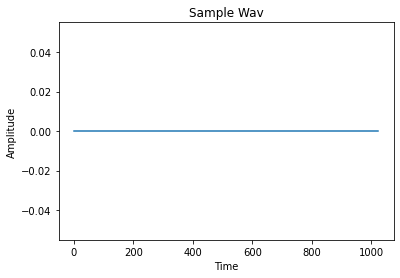

In [14]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

# read audio samples
input_data = read("full_audio.wav")
audio = input_data[1]
# plot the first 1024 samples
plt.plot(audio[0:1024])
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()

In [22]:
pwd


'/media/msaleem2/data/Development/IS APPS/FLASK/code'

In [21]:
ls "/home/msaleem2/Documents/Development/IS APPS/FLASK/static/audios/"

audio.wav  full_audio.wav  merge/  out/  output.wav  speech.wav


In [19]:
plotting_waveform("full_audio1.wav")

NameError: name 'random' is not defined

<Figure size 1080x360 with 0 Axes>

In [8]:
ls

audio.ipynb
audio.wav
c.wav
diarization_and_recognition.py
full_audio.wav
merge/
out/
output.wav
quantized_and_optimized_ECAPA_medium_nfft512_6epoch.ptl
speech.wav


In [24]:
for key in transcription.keys():
    print(transcription[key]['text'])
    print()

you wish to know all about my grandfather well he's nearly ninety three years old yet he still thinks I swiftly as of her she dresses himself in an old black frock-coat usually several buttons missing a long beard Queens tuition giving those who observe him up pronounce feeling of the utmost respect when he speaks his voice is just a bit cracked and clickers a bit each day he plays skillfully and resent on a small organ except in the winter when this newer Ice event he's so we take a short walk in the open-air each day to walk more but he always answers

you wish to know all about my grandfather ever he dresses himself in an old black frock-coat usually several buttons missing a long beard clings to his chin giving those who observe

you wish to know all about my grandfather, well he's nearly 92 years old and he still thinks as swiftly as ever he dresses himself in an old black frock-coat usually several buttons missing a long beard clings to his chicken getting those who deserve him u

In [30]:
from pydub import AudioSegment
sound1 = AudioSegment.from_file("./merge/1.wav", format="wav")
sound2 = AudioSegment.from_file("./merge/2.wav", format="wav")
sound3 = AudioSegment.from_file("./merge/3.wav", format="wav")
sound4 = AudioSegment.from_file("./merge/4.wav", format="wav")
sound5 = AudioSegment.from_file("./merge/5.wav", format="wav")

# sound1 6 dB louder


# sound1, with sound2 appended (use louder instead of sound1 to append the louder version)
combined = sound1 + sound2 + sound3 + sound4 +sound5

# simple export
file_handle = combined.export("output.wav", format="wav")

In [20]:
import glob

In [24]:
glob.glob("out/*")

['out/seg0_speaker0_speakerseg1.wav',
 'out/seg3_speaker1_speakerseg4.wav',
 'out/seg1_speaker1_speakerseg12.wav',
 'out/seg6_speaker3_speakerseg4.wav',
 'out/seg9_speaker4_speakerseg2.wav',
 'out/seg2_speaker1_speakerseg2.wav',
 'out/seg1_speaker1_speakerseg0.wav',
 'out/seg7_speaker4_speakerseg0.wav',
 'out/seg8_speaker3_speakerseg9.wav',
 'out/seg5_speaker3_speakerseg0.wav',
 'out/seg8_speaker4_speakerseg3.wav',
 'out/seg4_speaker2_speakerseg6.wav',
 'out/seg2_speaker2_speakerseg0.wav',
 'out/seg4_speaker2_speakerseg5.wav',
 'out/seg7_speaker3_speakerseg6.wav',
 'out/seg9_speaker4_speakerseg6.wav',
 'out/seg3_speaker2_speakerseg3.wav',
 'out/seg0_speaker0_speakerseg7.wav',
 'out/seg10_speaker4_speakerseg8.wav',
 'out/seg10_speaker4_speakerseg4.wav']

In [67]:
pip install numpy==1.22

     |████████████████████████████████| 16.8 MB 3.3 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
torchvision 0.11.1 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
tensorflow-federated 0.20.0 requires numpy~=1.21.4, but you have numpy 1.22.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [33]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

In [1]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

In [2]:
audio_clip_cafe, rate = sf.read("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withnoise.wav")

audio_clip_cafe.shape,sum(audio_clip_cafe)

((200542,), 0.5828857421875)

In [3]:
audio_clip_cafe, rate = sf.read("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withoutnoise.wav")

audio_clip_cafe.shape,sum(audio_clip_cafe)
IPython.display.Audio(data=audio_clip_cafe, rate=rate)


In [4]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate )


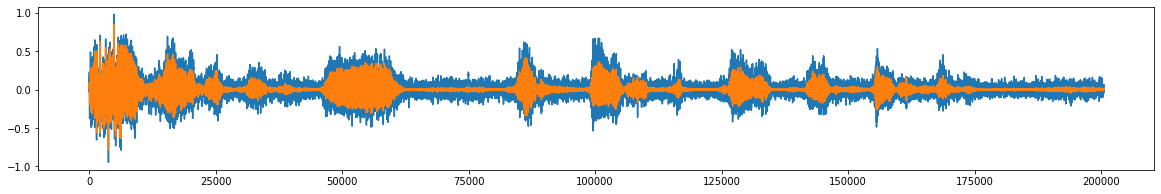

In [5]:

audio_clip_cafe, rate = sf.read("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withnoise.wav")



reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=1,stationary=False)
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)
IPython.display.Audio(data=reduced_noise, rate=rate)


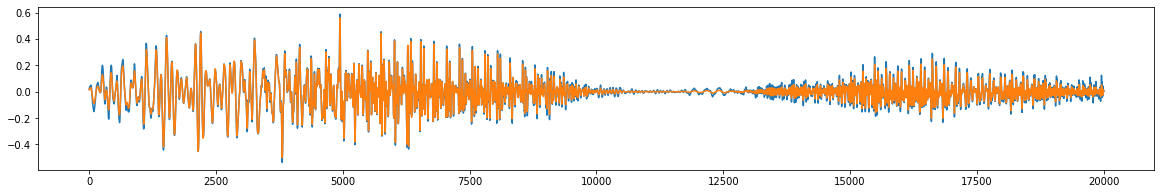

In [6]:

audio_clip_cafe, rate = sf.read("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withoutnoise.wav")



reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=1,stationary=False)
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)
IPython.display.Audio(data=reduced_noise, rate=rate)


In [7]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

In [8]:
noise_rate

44100

In [9]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = audio_clip_cafe + noise_clip
IPython.display.Audio(data=audio_clip_cafe, rate=rate)


ValueError: operands could not be broadcast together with shapes (20000,) (200542,) 

In [10]:
write("withnoise11.wav",  data=audio_clip_cafe, rate=noise_rate)


NameError: name 'write' is not defined

In [11]:
write("withnoise.wav", rate, audio_clip_cafe)
write("withoutnoise.wav", rate, audio_clip_cafe)

NameError: name 'write' is not defined

In [12]:
audio_clip_cafe, rate = sf.read("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withnoise.wav")


sg = SpectralGateStationary(
    y = audio_clip_cafe,
    sr = rate,
    y_noise=None,
    prop_decrease=1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    n_std_thresh_stationary=1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary=True,
    use_tqdm=False,
    n_jobs=1,
)
subset_noise_reduce = sg.get_traces(start_frame = 0, end_frame = 100000)

IPython.display.Audio(data=subset_noise_reduce, rate=rate)
#sf.write("/media/msaleem2/data/Development/IS APPS/FLASK/static/audios/withoutnoise.wav",subset_noise_reduce, rate)

NameError: name 'SpectralGateStationary' is not defined

AttributeError: 'Figure' object has no attribute 'rcParams'

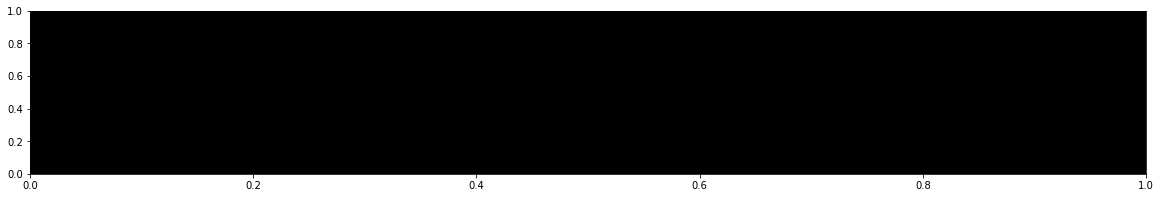

In [17]:
plt, ax = plt.subplots(figsize=(20, 3))
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['savefig.facecolor'] = 'black'

plt.plot(audio_clip_cafe)
plt.plot(audio_clip_cafe)
plt.yticks([])
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()
plt.savefig(
        "/media/msaleem2/data/Development/IS APPS/FLASK/static/img/noiseremoval.jpg")

NameError: name 'subset_noise_reduce' is not defined

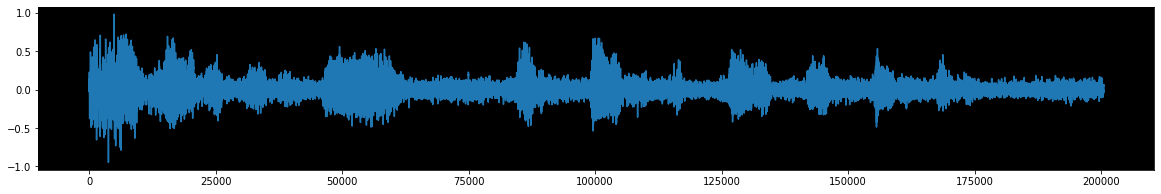

In [14]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(subset_noise_reduce)

In [16]:
from scipy.io.wavfile import write

In [19]:
write("example.wav", rate, subset_noise_reduce)

In [31]:
ls  ../static/audios/

audio.wav  full_audio1.wav  out/  speech.wav  withnoise.wav  withoutnoise.wav


In [30]:
ls ..

 app.py   langdetectmodel.pkl       __pycache__/   templates/
 code/   'Language Detection.csv'   static/
